In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

import pickle
from utils import scatter_plot
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor as XGBRegressor

In [2]:
train = pd.read_csv('./data/SynDepth_train_set.csv', converters={'site_no': str}, low_memory=False)
test = pd.read_csv('./data/SynDepth_test_set.csv', converters={'site_no': str}, low_memory=False)

In [3]:
X_train = train.drop(columns=['site_no', 'mean_depth_va'])
X_test = test.drop(columns=['site_no', 'mean_depth_va'])

y_train = train[['mean_depth_va']]
y_test = test[['mean_depth_va']]

In [4]:
X_train_ = X_train.copy(deep=True)
X_train_['drain_area_va'] = np.log10(X_train['drain_area_va'])
X_train_['q_va'] = np.log10(X_train['q_va'])
X_train_['stream_wdth_va'] = np.log10(X_train['stream_wdth_va'])
X_train_['xsec_area_va'] = np.log10(X_train['xsec_area_va'])
y_train_= np.log10(y_train)

X_scaler = StandardScaler()
X_train_ = X_scaler.fit_transform(X_train_).astype('float32')

y_scaler = StandardScaler()
y_train_ = y_scaler.fit_transform(np.array(y_train_).reshape(-1, 1)).astype('float32').ravel()

X_test_ = X_test.copy(deep=True)
X_test_['drain_area_va'] = np.log10(X_test['drain_area_va'])
X_test_['q_va'] = np.log10(X_test['q_va'])
X_test_['stream_wdth_va'] = np.log10(X_test['stream_wdth_va'])
X_test_['xsec_area_va'] = np.log10(X_test['xsec_area_va'])

X_test_ = X_scaler.transform(X_test_).astype('float32')

In [5]:
with open('./data/ml_weights/rf_best_model', "rb") as fp:
    rfr = pickle.load(fp)

with open('./data/ml_weights/xgb_best_model', "rb") as fp:
    xgb = pickle.load(fp)

with open('./data/ml_weights/mlp_best_model', "rb") as fp:
    mlp = pickle.load(fp)

with open('./data/ml_weights/svr_best_model', "rb") as fp:
    svr = pickle.load(fp)

In [22]:
estimators = [('rf', rfr), ('xgb', xgb), ('mlp', mlp), ('svr', svr)]
reg = StackingRegressor(estimators=estimators, cv='prefit', final_estimator=XGBRegressor(learning_rate=0.15, n_estimators=200, random_state=42))

In [23]:
# reg.fit(X_train.to_numpy(), y_train.to_numpy().ravel())
reg.fit(X_train_, y_train_)

StackingRegressor(cv='prefit',
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=14,
                                                     max_features='auto',
                                                     min_samples_split=5,
                                                     n_estimators=10, n_jobs=-1,
                                                     random_state=42)),
                              ('xgb',
                               GradientBoostingRegressor(learning_rate=0.14264219278216356,
                                                         n_estimators=400,
                                                         random_state=42)),
                              ('mlp',
                               MLPRegressor(alpha=0.05,
                                            hidden_layer_sizes=(50, 50, 50),
                                            max_iter=100)),
                              ('svr', SVR(C=10, gamma=0.1))],
                  final_estimator=GradientBoostingRegressor(learning_rate=0.15,
                                                            n_estimators=200,
                                                            random_state=42))

In [24]:
ens_pred = reg.predict(X_test_)
ens_pred = y_scaler.inverse_transform(ens_pred.reshape(-1, 1)).ravel()
ens_pred = 10 ** ens_pred

NSE: 0.9982, R2: 0.9982, PBias: -0.2022, MSE: 0.2647


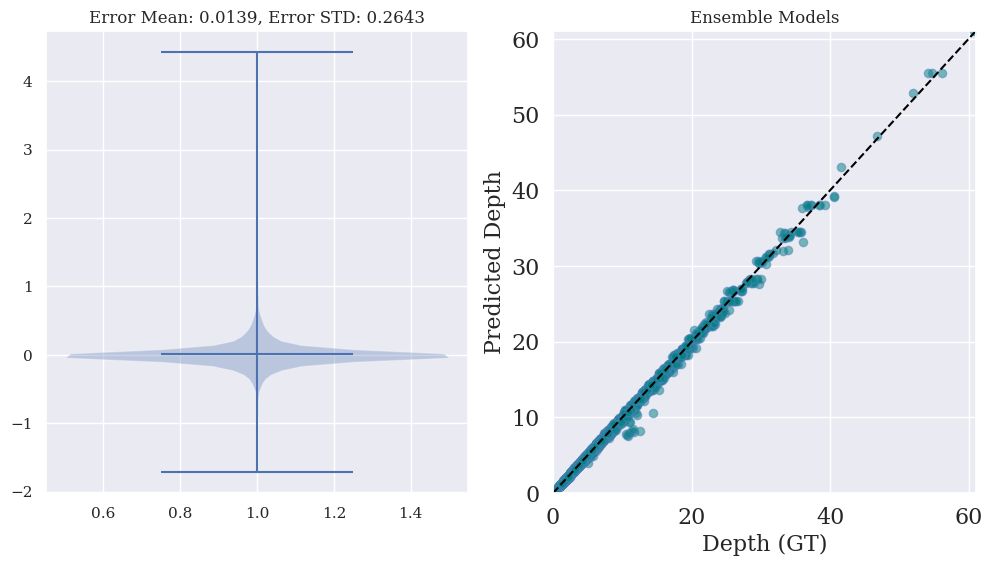

In [25]:
scatter_plot(y_test, ens_pred, model_name='Ensemble Models')

In [29]:
with open('./data/ml_weights/ensemble_model', "wb") as fp:
    pickle.dump(reg, fp)

In [6]:
rfr_pred = rfr.predict(X_test.to_numpy())
xgb_pred = xgb.predict(X_test.to_numpy())
mlp_pred = mlp.predict(X_test_); mlp_pred = y_scaler.inverse_transform(mlp_pred.reshape(-1, 1)).ravel(); mlp_pred = 10 ** mlp_pred
svr_pred = svr.predict(X_test_); svr_pred = y_scaler.inverse_transform(svr_pred.reshape(-1, 1)).ravel(); svr_pred = 10 ** svr_pred

In [7]:
mlp_train_pred = mlp.predict(X_train_); mlp_train_pred = y_scaler.inverse_transform(mlp_train_pred.reshape(-1, 1)).ravel(); mlp_train_pred = 10 ** mlp_train_pred

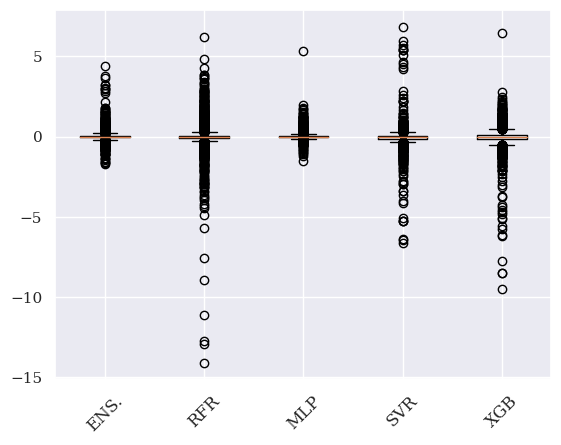

In [28]:
data = [y_test.to_numpy().ravel() - ens_pred,
        y_test.to_numpy().ravel() - rfr_pred,
        y_test.to_numpy().ravel() - mlp_pred,
        y_test.to_numpy().ravel() - svr_pred,
        y_test.to_numpy().ravel() - xgb_pred,
        ]

fig, ax = plt.subplots()
ax.boxplot(data)

ax.set_xticklabels(['ENS.', 'RFR', 'MLP', 'SVR', 'XGB'])
ax.tick_params(axis='x', labelrotation=45, labelsize=12)

ax.grid(True)
plt.show()

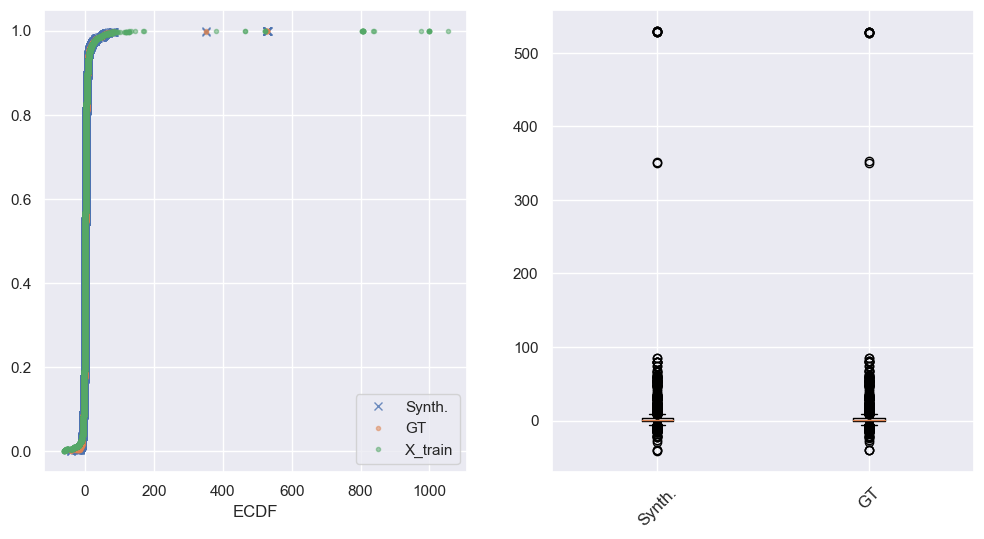

In [8]:
# data1 = test['xsec_area_va'].to_numpy().ravel() / test['stream_wdth_va'].to_numpy().ravel() - mlp_pred
# data2 = test['xsec_area_va'].to_numpy().ravel() / test['stream_wdth_va'].to_numpy().ravel() - test['mean_depth_va'].to_numpy().ravel()

data1 = test['stage_va'].to_numpy().ravel() - mlp_pred
data2 = test['stage_va'].to_numpy().ravel() - test['mean_depth_va'].to_numpy().ravel()
data3 = train['stage_va'].to_numpy().ravel() - mlp_train_pred

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

x1 = np.sort(data1)
y1 = np.arange(1, len(data1)+1) / len(data1)
ax1.plot(x1, y1, linestyle='none', marker='x', alpha=0.8, label='Synth.')

x2 = np.sort(data2)
y2 = np.arange(1, len(data2)+1) / len(data2)
ax1.plot(x2, y2, linestyle='none', marker='.', alpha=0.5, label='GT')

x3 = np.sort(data3)
y3 = np.arange(1, len(data3)+1) / len(data3)
ax1.plot(x3, y3, linestyle='none', marker='.', alpha=0.5, label='X_train')

ax1.set_xlabel(f'ECDF')
ax1.legend()

ax2.boxplot([data1, data2])
ax2.set_xticklabels(['Synth.', 'GT'])
ax2.tick_params(axis='x', labelrotation=45, labelsize=12)
ax2.grid(True)


plt.show()